In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import scipy.io
import scipy.signal
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
import zipfile, os

# Path to your zip on Drive
zip_path = '/content/drive/MyDrive/EEG_Project/EEG_128channels_resting_lanzhou_2015.zip'
extract_path = '/content/eeg_data'

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Zip extracted")


✅ Zip extracted


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx to subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx


In [ ]:
import pandas as pd

subject_info = pd.read_excel('subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx')
subject_info.rename(columns={'subject id': 'subject_id'}, inplace=True)


In [ ]:
# Load Excel file
subject_info = pd.read_excel('/content/subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx')

# Clean column names
subject_info.columns = [col.strip().lower() for col in subject_info.columns]

# Rename 'subject id' → 'subject_id'
subject_info.rename(columns={'subject id': 'subject_id'}, inplace=True)

# Optional: preview columns
print("Cleaned Columns:", subject_info.columns.tolist())


Cleaned Columns: ['subject_id', 'type', 'age', 'gender', 'education（years）', 'phq-9', 'ctq-sf', 'les', 'ssrs', 'gad-7', 'psqi', 'unnamed: 11', 'unnamed: 12']


In [ ]:
# Make sure your Excel was uploaded earlier
excel_path = list(uploaded.keys())[0]

subject_info = pd.read_excel(excel_path)
subject_info.columns = [col.strip().lower() for col in subject_info.columns]
subject_info.rename(columns={'subject id': 'subject_id'}, inplace=True)
subject_info['subject_id'] = subject_info['subject_id'].astype(str).str[-5:]
label_map = {'MDD': 1, 'HC': 0}

print(subject_info.head())


  subject_id type  age gender  education（years）  phq-9  ctq-sf  les  ssrs  \
0      10002  MDD   18      F                12     23      77 -143    31   
1      10004  MDD   25      F                19     12      53  -44    38   
2      10005  MDD   20      M                16     19      49   -3    28   
3      10006  MDD   42      M                16     16      59  -30    40   
4      10008  MDD   42      M                12     17      66  -71    44   

   gad-7  psqi  unnamed: 11                              unnamed: 12  
0     18    12          NaN                             abbreviation  
1     13    11          NaN          MDD = Major Depressive Disorder  
2     11     5          NaN                     HC = Healthy Control  
3     12     9          NaN     PHQ-9 = Patient Health Questionnaire  
4     18    13          NaN  CTQ-SF = Childhood Trauma Questionnaire  


In [ ]:
def segment_signal(data, window_length=256, step=128):
    channels, total_len = data.shape
    segments = []
    for start in range(0, total_len - window_length + 1, step):
        window = data[:, start:start + window_length]
        segments.append(window)
    return np.array(segments)

def extract_subject_id(filename):
    digits = re.findall(r'\d+', filename)
    if digits:
        return digits[0][-5:]
    return None


In [ ]:
import gc

# Define bandpass filter
def butter_bandpass_filter(data, lowcut=1, highcut=50, fs=256, order=4):
    b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    return filtfilt(b, a, data)

# Preprocess one segment
def preprocess_segment(segment):
    clean = []
    for ch in segment:
        try:
            filt = butter_bandpass_filter(ch)
            if np.any(np.abs(filt) > 1e5):  # artifact rejection
                return None
            norm = (filt - np.mean(filt)) / np.std(filt)
            clean.append(norm)
        except:
            return None
    return np.array(clean)

# Feature extraction
bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}
def bandpower(sig, fs=256):
    freqs, psd = welch(sig, fs, nperseg=128)
    features = []
    for band, (low, high) in bands.items():
        mask = (freqs >= low) & (freqs <= high)
        bp = np.sum(psd[mask])
        features.append(bp)
    return features

def extract_features(segment):
    feat = []
    for ch in segment:
        bp_feats = bandpower(ch)
        time_feats = [np.mean(ch), np.std(ch), np.ptp(ch)]
        feat.extend(bp_feats + time_feats)
    return feat

# MAIN LOOP
mat_folder = '/content/eeg_data/EEG_128channels_resting_lanzhou_2015'
mat_files = [f for f in os.listdir(mat_folder) if f.endswith('.mat')]

X_feats = []
y_labels = []

for idx, fname in enumerate(mat_files):
    mat_path = os.path.join(mat_folder, fname)
    try:
        mat = scipy.io.loadmat(mat_path)
        data_key = [k for k in mat.keys() if not k.startswith('__')][0]
        data = mat[data_key]
        segs = segment_signal(data)

        sid = extract_subject_id(fname)
        row = subject_info[subject_info['subject_id'] == sid]
        if row.empty:
            continue
        label = label_map.get(row['type'].values[0], -1)
        if label == -1:
            continue

        for seg in segs:
            clean = preprocess_segment(seg)
            if clean is None:
                continue
            feats = extract_features(clean)
            X_feats.append(feats)
            y_labels.append(label)
    except Exception as e:
        print(f"Error with {fname}: {e}")
    if (idx+1) % 5 == 0:
        print(f"Processed {idx+1}/{len(mat_files)} files")
        gc.collect()

X_feats = np.array(X_feats)
y_labels = np.array(y_labels)

print("✅ Feature matrix shape:", X_feats.shape)
print("✅ Labels shape:", y_labels.shape)


/tmp/ipython-input-9-373229460.py:16: RuntimeWarning: invalid value encountered in divide
  norm = (filt - np.mean(filt)) / np.std(filt)


Processed 5/53 files
Processed 10/53 files
Processed 15/53 files
Processed 20/53 files
Processed 25/53 files
Processed 30/53 files
Processed 35/53 files
Processed 40/53 files
Processed 45/53 files
Processed 50/53 files
✅ Feature matrix shape: (31293, 903)
✅ Labels shape: (31293,)


In [ ]:
!pip install antropy


In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_feats, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print("✅ Train:", X_train.shape, y_train.shape)
print("✅ Test:", X_test.shape, y_test.shape)


✅ Train: (25034, 903) (25034,)
✅ Test: (6259, 903) (6259,)


In [ ]:
from sklearn.impute import SimpleImputer

# Impute NaNs with column mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

print("✅ Imputation done!")
print("Remaining NaNs in X_train:", np.isnan(X_train_imputed).sum())
print("Remaining NaNs in X_test:", np.isnan(X_test_imputed).sum())


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [896 897 898 899 900 901 902]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [896 897 898 899 900 901 902]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


✅ Imputation done!
Remaining NaNs in X_train: 0
Remaining NaNs in X_test: 0


In [ ]:
# Remove columns that are completely NaN in both train and test
all_nan_cols_train = np.all(np.isnan(X_train), axis=0)
all_nan_cols_test = np.all(np.isnan(X_test), axis=0)
all_nan_cols = all_nan_cols_train & all_nan_cols_test

print("Columns to drop:", np.where(all_nan_cols)[0])

X_train_clean = X_train[:, ~all_nan_cols]
X_test_clean = X_test[:, ~all_nan_cols]

print("✅ New shape:", X_train_clean.shape)


Columns to drop: [896 897 898 899 900 901 902]
✅ New shape: (25034, 896)


In [ ]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_clean)
X_test_imputed = imputer.transform(X_test_clean)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


In [ ]:
print("✅ Final check")
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("NaNs in X_test_scaled:", np.isnan(X_test_scaled).sum())
print("Train mean/std:", np.mean(X_train_scaled), np.std(X_train_scaled))


✅ Final check
NaNs in X_train_scaled: 0
NaNs in X_test_scaled: 0
Train mean/std: 6.426746688388128e-18 0.9258200997725515


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 32
input_dim = X_train_scaled.shape[1]   # NOW 896

# Encoder
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(256, activation='relu')(encoder_inputs)a
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.val_loss_tracker = keras.metrics.Mean(name="val_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.loss_fn = keras.losses.MeanSquaredError()

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            reconstruction = self.decoder(z)
            reconstruction_loss = self.loss_fn(data, reconstruction)
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + 0.0001 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = self.loss_fn(data, reconstruction)
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        total_loss = reconstruction_loss + 0.0001 * kl_loss
        self.val_loss_tracker.update_state(total_loss)
        return {"val_loss": self.val_loss_tracker.result()}

# Instantiate
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0))


In [ ]:
vae.fit(
    X_train_scaled,
    epochs=30,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.8172 - val_val_loss: 0.5749
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5444 - val_val_loss: 0.4791
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4643 - val_val_loss: 0.4382
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4299 - val_val_loss: 0.4133
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4047 - val_val_loss: 0.3959
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3883 - val_val_loss: 0.3832
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3770 - val_val_loss: 0.3734
Epoch 8/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3673 - val_val_loss: 0.3656
Epoch 9/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3617 - val_val_loss: 0.3594
Epoch 10/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3532 - val_val_loss: 0.3541
Epoch 11/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3502 - val_val_loss: 0.3494
Epoch 1

In [ ]:
# Encode the training and test data
z_mean_train, _, _ = vae.encoder.predict(X_train_scaled)
z_mean_test, _, _ = vae.encoder.predict(X_test_scaled)
print("Latent space shapes:")
print("Train:", z_mean_train.shape)
print("Test:", z_mean_test.shape)



783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Latent space shapes:
Train: (25034, 32)
Test: (6259, 32)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Instantiate the classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on latent features
rf.fit(z_mean_train, y_train)

# Predict
y_pred = rf.predict(z_mean_test)


In [ ]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3428
           1       0.99      0.98      0.98      2831

    accuracy                           0.98      6259
   macro avg       0.98      0.98      0.98      6259
weighted avg       0.98      0.98      0.98      6259

Confusion Matrix:
[[3387   41]
 [  65 2766]]


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [ ]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(z_mean_train, y_train)


SVC(probability=True, random_state=42)

In [ ]:
y_pred_svm = svm.predict(z_mean_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3428
           1       0.92      0.94      0.93      2831

    accuracy                           0.94      6259
   macro avg       0.93      0.94      0.93      6259
weighted avg       0.94      0.94      0.94      6259

Confusion Matrix:
[[3186  242]
 [ 163 2668]]


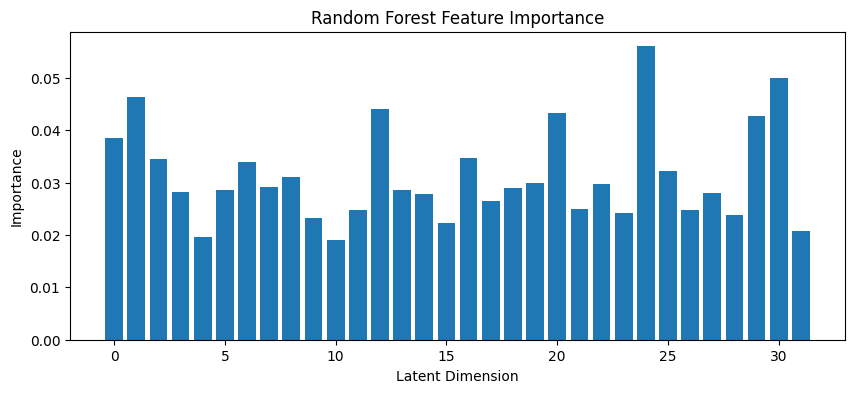

In [ ]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
plt.figure(figsize=(10,4))
plt.bar(range(len(importances)), importances)
plt.xlabel('Latent Dimension')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()


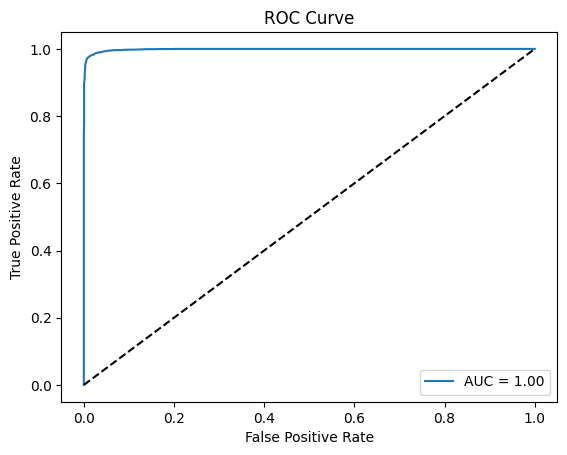

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

probs = rf.predict_proba(z_mean_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


AUC: 0.988


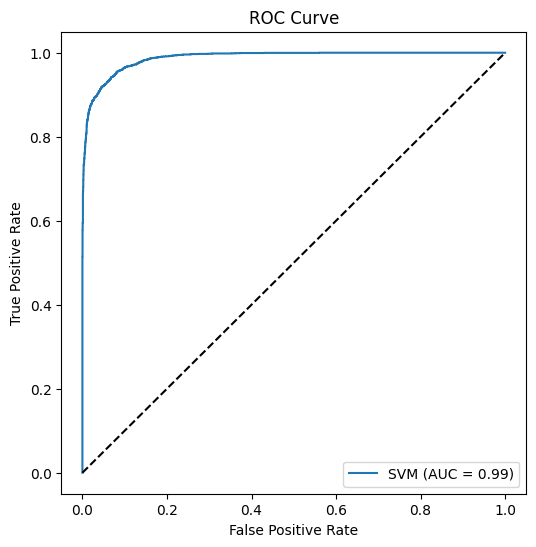

In [ ]:
probs_svm = svm.predict_proba(z_mean_test)[:,1]
auc_svm = roc_auc_score(y_test, probs_svm)
print(f"AUC: {auc_svm:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, probs_svm)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(z_mean_train, y_train)

preds = clf.predict(z_mean_test)
print("LogisticRegression classification report:")
print(classification_report(y_test, preds))


LogisticRegression classification report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3428
           1       0.73      0.74      0.73      2831

    accuracy                           0.76      6259
   macro avg       0.76      0.76      0.76      6259
weighted avg       0.76      0.76      0.76      6259



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
classifier = models.Sequential([
    layers.Input(shape=(z_mean_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

classifier.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = classifier.fit(
    z_mean_train,
    y_train,
    validation_data=(z_mean_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)


Epoch 1/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5266 - auc: 0.5489 - loss: 1.1522 - val_accuracy: 0.7372 - val_auc: 0.8552 - val_loss: 0.4742
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6758 - auc: 0.7607 - loss: 0.5849 - val_accuracy: 0.7910 - val_auc: 0.9095 - val_loss: 0.3914
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7438 - auc: 0.8406 - loss: 0.4727 - val_accuracy: 0.8230 - val_auc: 0.9289 - val_loss: 0.3519
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7801 - auc: 0.8847 - loss: 0.4055 - val_accuracy: 0.8495 - val_auc: 0.9428 - val_loss: 0.3200
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8077 - auc: 0.9094 - loss: 0.3652 - val_accuracy: 0.8691 - val_auc: 0.9539 - val_loss: 0.2936
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8224 - auc: 0.9231 - loss: 0.3370 - val_accuracy: 0.8808 - val_auc: 0.9621 - val_loss: 0.2721
Epoch 7/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 

**Figure:** Loss and Accuracy curves for the MLP model during training.

**Figure:** Loss and Accuracy curves for the MLP model for EEG resting state data during training.

In [ ]:
results = classifier.evaluate(z_mean_test, y_test)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test AUC: {results[2]:.4f}")


196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9810 - auc: 0.9986 - loss: 0.0511
Test Loss: 0.0537
Test Accuracy: 0.9799
Test AUC: 0.9983


In [ ]:
from sklearn.metrics import classification_report

# Predict probabilities
mlp_probs = classifier.predict(z_mean_test).ravel()
mlp_preds = (mlp_probs >= 0.5).astype(int)

# Report
print("MLP classification report:")
print(classification_report(y_test, mlp_preds, target_names=["HC (0)", "MDD (1)"]))


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MLP classification report:
              precision    recall  f1-score   support

      HC (0)       0.98      0.99      0.98      3428
     MDD (1)       0.98      0.97      0.98      2831

    accuracy                           0.98      6259
   macro avg       0.98      0.98      0.98      6259
weighted avg       0.98      0.98      0.98      6259



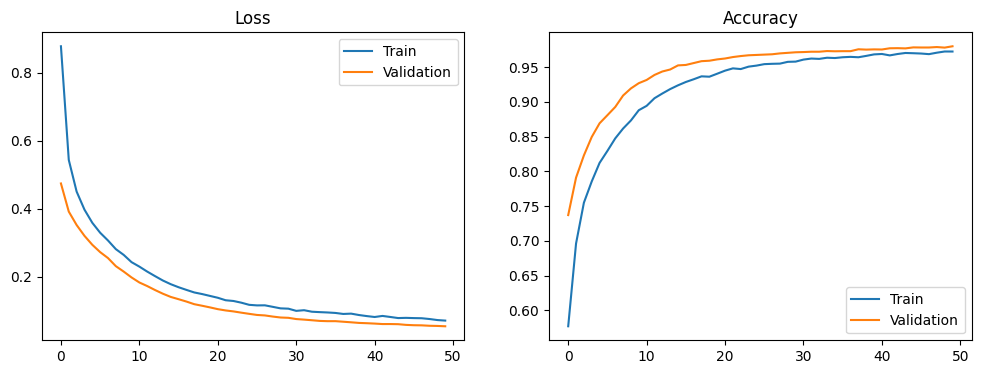

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.show()


196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUC: 0.998


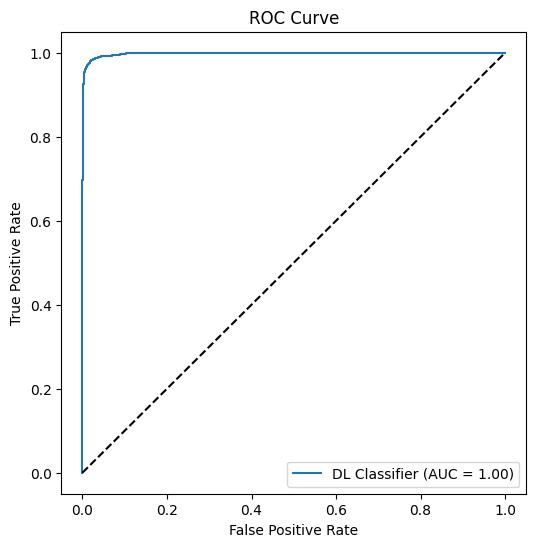

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

probs_dl = classifier.predict(z_mean_test).ravel()
auc_dl = roc_auc_score(y_test, probs_dl)
print(f"AUC: {auc_dl:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, probs_dl)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"DL Classifier (AUC = {auc_dl:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
# Reshape latent vectors to (samples, 32, 1)
X_train_cnn = np.expand_dims(z_mean_train, axis=-1)
X_test_cnn = np.expand_dims(z_mean_test, axis=-1)

print(X_train_cnn.shape)  # (num_samples, 32, 1)


(25034, 32, 1)


In [ ]:
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Input(shape=(32, 1)),
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,561 (41.25 KB)

 Trainable params: 10,561 (41.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)


Epoch 1/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5481 - auc_1: 0.5585 - loss: 0.6799 - val_accuracy: 0.5701 - val_auc_1: 0.6288 - val_loss: 0.6608
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5851 - auc_1: 0.6488 - loss: 0.6555 - val_accuracy: 0.6273 - val_auc_1: 0.7095 - val_loss: 0.6332
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6399 - auc_1: 0.7147 - loss: 0.6269 - val_accuracy: 0.6950 - val_auc_1: 0.7775 - val_loss: 0.5921
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6975 - auc_1: 0.7780 - loss: 0.5860 - val_accuracy: 0.7354 - val_auc_1: 0.8305 - val_loss: 0.5433
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7386 - auc_1: 0.8265 - loss: 0.5384 - val_accuracy: 0.7706 - val_auc_1: 0.8662 - val_loss: 0.4984
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7707 - auc_1: 0.8623 - loss: 0.4939 - val_accuracy: 0.7768 - val_auc_1: 0.8820 - val_loss: 0.4650
Epoch 7/50
392/3

In [ ]:
results = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test AUC: {results[2]:.4f}")


196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9134 - auc_1: 0.9750 - loss: 0.2031
Test Loss: 0.1995
Test Accuracy: 0.9155
Test AUC: 0.9760


In [ ]:
# Predict probabilities
cnn_probs = cnn_model.predict(X_test_cnn).ravel()
cnn_preds = (cnn_probs >= 0.5).astype(int)

# Report
print("CNN classification report:")
print(classification_report(y_test, cnn_preds, target_names=["HC (0)", "MDD (1)"]))


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN classification report:
              precision    recall  f1-score   support

      HC (0)       0.92      0.93      0.92      3428
     MDD (1)       0.91      0.90      0.91      2831

    accuracy                           0.92      6259
   macro avg       0.92      0.91      0.91      6259
weighted avg       0.92      0.92      0.92      6259



196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
AUC: 0.976


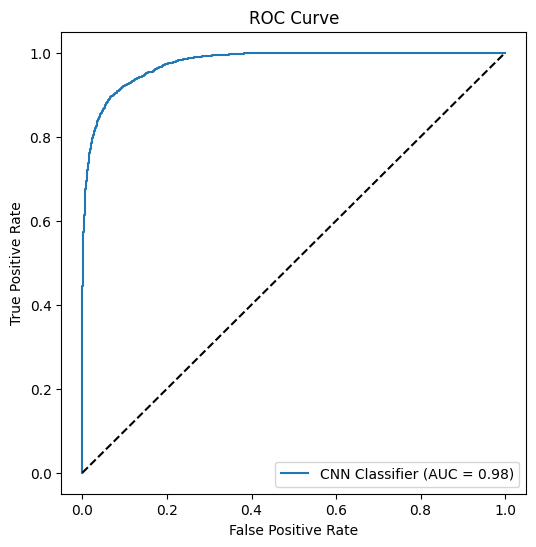

In [ ]:
probs_cnn = cnn_model.predict(X_test_cnn).ravel()
auc_cnn = roc_auc_score(y_test, probs_cnn)
print(f"AUC: {auc_cnn:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, probs_cnn)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"CNN Classifier (AUC = {auc_cnn:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
